In [26]:
import numpy as np
import pandas as pd
import preprocessor as p   # tweets preprocessor
import re
import spacy
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from  nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import keras

from sklearn import metrics

import itertools 
import collections
from collections import defaultdict
pd.options.display.max_colwidth = 200
%matplotlib inline

In [27]:
nlp = spacy.load("en_core_web_md")
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [28]:
##Import dataset 
df = pd.read_csv("/Data Science/DSC/Natural Language Processing/dataset/Tweets.csv")

In [29]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Exploratory Data Analysis 

In [30]:
## check the distribution of sentiment types
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [31]:
## generate 'positive' dataset
df_positive = df[df['airline_sentiment'] == 'positive']
df_positive.shape

(2363, 15)

In [32]:
## generate 'neutral' dataset
df_neutral = df[df['airline_sentiment'] == 'neutral']
df_neutral.shape

(3099, 15)

In [33]:
## generate 'negative' dataset
df_negative = df[df['airline_sentiment'] == 'negative']
df_negative.shape

(9178, 15)

In [34]:
## check " negative reason" for 'negative' dataset
df_negative.groupby('negativereason')['negativereason'].count().sort_values(ascending=False)

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [35]:
## check positive review distribution by airlines
df_positive.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Southwest         570
Delta             544
United            492
American          336
US Airways        269
Virgin America    152
Name: airline, dtype: int64

In [36]:
##  check negative review distribution by airlines
df_negative.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
United            2633
US Airways        2263
American          1960
Southwest         1186
Delta              955
Virgin America     181
Name: airline, dtype: int64

In [37]:
##  check neutral review distribution by airlines
df_neutral.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Delta             723
United            697
Southwest         664
American          463
US Airways        381
Virgin America    171
Name: airline, dtype: int64

In [38]:
## check missing values 
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [39]:
##  calculate  and view the frequency of each word
import nltk
from nltk.tokenize import word_tokenize

reviews = df.text.str.cat(sep=' ')
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

20127


['@',
 '.',
 'to',
 'I',
 'the',
 '!',
 '?',
 'a',
 ',',
 'for',
 'you',
 'united',
 'on',
 '#',
 'and',
 'flight',
 'my',
 'USAirways',
 'AmericanAir',
 'is',
 'in',
 'SouthwestAir',
 'JetBlue',
 'of',
 'it',
 "n't",
 ':',
 'me',
 'have',
 'was',
 'that',
 'your',
 'with',
 "'s",
 'at',
 'not',
 'get',
 'do',
 'be',
 'from',
 'this',
 'http',
 'no',
 'but',
 'are',
 'Cancelled',
 '...',
 'we',
 'an',
 ';']

In [40]:
tokenizer.tokenize('I am steve')

['I', 'am', 'steve']

In [41]:
frequency_dist

FreqDist({'@': 16583, '.': 13590, 'to': 8589, 'I': 6347, 'the': 5796, '!': 5312, '?': 4678, 'a': 4364, ',': 4156, 'for': 3953, ...})

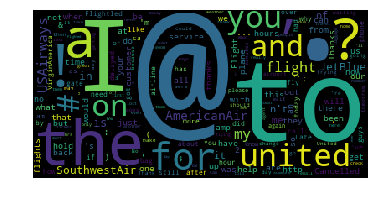

In [42]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Train test split

In [43]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['airline_sentiment'],test_size=0.33, random_state=53)

# Text Data Preprocessing

## define some functions

In [91]:
## Expand contractions

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [92]:
## Remove special characters

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', ' ', text)
    return text

In [93]:
## Lemmatization

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [94]:
## remove stopwords

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [95]:
def clean_tweets(df_tmp):
    tempArr = []
    for line in df_tmp:
    #send to tweet_processor
        tmpL = p.clean(line)
        tmpL = expand_contractions(tmpL.lower())
        tmpL = remove_special_characters(tmpL)
        tmpL = lemmatize_text(tmpL)
        tmpL = remove_stopwords(tmpL)
    #remove puctuation
        #tmpL = REPLACE_NO_SPACE.sub("", tmpL) 
        #tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
        tempArr.append(tmpL)
    return tempArr

In [121]:
# clean both train and test dataset

X_train_cleaned = clean_tweets(X_train)
X_test_cleaned = clean_tweets(X_test)

## CountVectorization

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_train= count_vectorizer.fit_transform(X_train_cleaned)
count_test= count_vectorizer.transform(X_test_cleaned)

In [133]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_cleaned)
tfidf_test = tfidf_vectorizer.transform(X_test_cleaned)

In [136]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#   Model Building

## Naive Bayes using CountVectorization

In [139]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7491721854304636

In [140]:
metrics.confusion_matrix(y_test,pred,labels=nb_classifier.classes_)

array([[2824,  118,   62],
       [ 572,  376,   79],
       [ 316,   65,  420]])

In [141]:
labels = nb_classifier.classes_
conf_df = pd.DataFrame(metrics.confusion_matrix(y_test, pred), columns=labels, index=labels)
conf_df.index.name = 'True labels'

In [142]:
conf_df

,negative,neutral,positive
True labels,,,
negative,2824,118,62
neutral,572,376,79
positive,316,65,420


## Cross validation

In [144]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1))

[0.75331295 0.74821611 0.74108053 0.74617737 0.74923547 0.73700306
 0.75229358 0.73496432 0.75612245 0.7244898 ]


## SVC using using CountVectorization

In [146]:
svc_classifier = SVC()
svc_classifier.fit(count_train,y_train)
pred = svc_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7692466887417219

## Cross validation

In [147]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1))

[0.75433231 0.76248726 0.77166157 0.76044852 0.74923547 0.745158
 0.78491335 0.745158   0.77244898 0.73163265]


## Naive Bayes using Tfidf

In [148]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.6841887417218543

## Cross validation

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1))

## SVC using Tfidf

In [151]:
svc_classifier = SVC()
svc_classifier.fit(tfidf_train,y_train)
pred = svc_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.7651076158940397

## cross validation

In [154]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1))

[0.76248726 0.75637105 0.75637105 0.75229358 0.75331295 0.72986748
 0.76962283 0.73598369 0.76122449 0.7255102 ]
